In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Epileptic Seizure Recognition.csv')
print(df.head())

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]


In [4]:
len(df)

11500

In [5]:
df['y'].replace({2: 0, 3: 0, 4: 0, 5: 0}, inplace=True)

<ipython-input-5-1eb1ac7605ee>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['y'].replace({2: 0, 3: 0, 4: 0, 5: 0}, inplace=True)


In [6]:
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [7]:
df['y'].value_counts()

,count
y,
0,9200
1,2300


In [8]:
X = df.drop('y', axis=1)
y = df['y']

In [9]:
keys = X['Unnamed']
X = X.drop(columns=['Unnamed'])

In [10]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [11]:
# class 1 oversampling 2300 -> 5000
smote = SMOTE(sampling_strategy={1: 5000}, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

n_original = len(X)
n_synthetic = len(X_smote) - n_original

keys_smote = pd.Series(
    list(keys) + [f"synthetic_{i}" for i in range(n_synthetic)],
    name="Unnamed"
)
# class 0 undersampling 9200 -> 5000
nm = NearMiss(version=1, n_neighbors=3)
X_final, y_final = nm.fit_resample(X_smote, y_smote)

keys_final = keys_smote.iloc[nm.sample_indices_].reset_index(drop=True)

df_final = pd.concat([
    keys_final,
    pd.DataFrame(X_final, columns=X.columns),
    pd.Series(y_final, name='y')
], axis=1)

print(df_final['y'].value_counts())
print(df_final.head())

y
0    5000
1    5000
Name: count, dtype: int64
      Unnamed  X1  X2  X3  X4  X5  X6  X7  X8  X9  ...  X170  X171  X172  \
0  X13.V1.122  40  36  31  23  13   9   2  -1  -3  ...   -11   -13   -15   
1  X17.V1.862  49  43  42  36  32  28  22  12   2  ...   -25   -26   -31   
2   X6.V1.862  24  26  30  27  27  28  29  25  29  ...   -25   -30   -30   
3  X12.V1.802  29  35  38  32  26  24  28  34  40  ...   -32   -32   -29   
4   X5.V1.415 -12  -5   2   3   1   4   5   6   6  ...   -14   -12    -7   

   X173  X174  X175  X176  X177  X178  y  
0   -17   -20   -30   -37   -49   -59  0  
1   -34   -31   -28   -23   -19   -16  0  
2   -23   -17    -9     1     6    13  0  
3   -28   -33   -36   -32   -34   -32  0  
4   -10   -14   -18   -13    -9    -3  0  

[5 rows x 180 columns]


In [12]:
taken = 0
takenfromclass0 = 0
takenfromclass1 = 0
nottaken = 0
for index, row in df.iterrows():
    file_name = row['Unnamed']
    matched = df_final.index[df_final['Unnamed'] == file_name].tolist()
    if matched:
      for idx in matched:
          matched_row = df_final.loc[idx]
          if matched_row['y'] == 1:
            takenfromclass1+=1
          else:
            takenfromclass0+=1
          taken+=1
    else:
      nottaken+=1
      if row['y'] == 1:
        print(f"Something Wrong, Minority class example is deleted")

print(taken, nottaken)
print(f"taken from class 0 {takenfromclass0}")
print(f"taken from class 1 {takenfromclass1}")

7300 4200
taken from class 0 5000
taken from class 1 2300


In [13]:
import numpy as np
X = df_final.drop(columns=['Unnamed', 'y']).astype(np.float32).values
y = df_final['y'].astype(np.float32).values

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
X_train, X_Val, y_train, y_Val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [16]:
X_train.shape

(6400, 178)

In [17]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
fitted_scaler = scaler.fit(X_train)
X_train = fitted_scaler.transform(X_train)
X_test = fitted_scaler.transform(X_test)
X_Val = fitted_scaler.transform(X_Val)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [19]:
X_train_tensor = torch.tensor(X_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test).unsqueeze(1)
X_val_tensor = torch.tensor(X_Val).unsqueeze(1)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)
y_val_tensor = torch.tensor(y_Val).unsqueeze(1)

In [20]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([6400, 1, 178])
torch.Size([6400, 1])


In [21]:
print(X_train_tensor[:1])

tensor([[[-0.3947, -0.1913, -0.0442,  0.0795,  0.1892,  0.1995,  0.2182,
           0.2072,  0.1786,  0.0363, -0.0354, -0.1228, -0.1964, -0.2609,
          -0.3684, -0.4261, -0.5000, -0.5862, -0.6271, -0.7155, -0.7778,
          -0.8534, -0.9643, -1.0796, -1.1754, -1.2650, -1.4123, -1.5317,
          -1.7234, -1.8198, -1.9338, -1.9828, -2.1478, -2.2870, -2.3707,
          -2.3761, -2.4087, -2.4348, -2.5166, -2.6818, -2.7946, -3.0565,
          -2.5739, -0.8070,  2.3333,  5.0893,  6.0364,  4.6621,  2.7909,
           1.0357,  0.2857, -0.0180, -0.0182,  0.2136,  0.0642, -0.1651,
          -0.5185, -0.7500, -0.6607, -0.4273, -0.0364,  0.2143,  0.3393,
           0.4775,  0.6518,  0.9730,  1.3571,  1.6899,  1.8899,  2.0909,
           2.3855,  2.7982,  3.0022,  2.8142,  2.3661,  1.7768,  1.3750,
           1.2054,  1.1261,  1.1091,  1.0090,  1.1667,  1.4679,  1.8559,
           2.0317,  1.7434,  1.1062,  0.3772, -0.3818, -0.9189, -1.1607,
          -1.3009, -1.3571, -1.4059, -1.3805, -1.32

In [22]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

In [23]:
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=len(X_test_tensor))

In [24]:
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=len(X_val_tensor))

In [25]:
class SeizurePredictor(nn.Module):
    def __init__(self):
        super(SeizurePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(178, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [26]:
def perform_training(model, train_loader, val_loader):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
      model.train()
      total_loss = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      train_losses.append(avg_loss)

      model.eval()
      total_val_loss = 0
      with torch.no_grad():
          for val_x, val_y in val_loader:
              val_outputs = model(val_x)
              val_loss = criterion(val_outputs, val_y)
              total_val_loss += val_loss.item()

      avg_val_loss = total_val_loss / len(val_loader)
      val_losses.append(avg_val_loss)

      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

  return train_losses,val_losses

In [27]:
import torch.optim as optim
criterion = nn.BCELoss()
epochs = 25

In [28]:
model1 = SeizurePredictor()
train_losses, val_losses = perform_training(model1, train_loader, val_loader)

Epoch [1/25], Train Loss: 0.2201, Val Loss: 0.0569
Epoch [2/25], Train Loss: 0.0471, Val Loss: 0.0282
Epoch [3/25], Train Loss: 0.0403, Val Loss: 0.0363
Epoch [4/25], Train Loss: 0.0246, Val Loss: 0.0235
Epoch [5/25], Train Loss: 0.0213, Val Loss: 0.0177
Epoch [6/25], Train Loss: 0.0206, Val Loss: 0.0181
Epoch [7/25], Train Loss: 0.0146, Val Loss: 0.0212
Epoch [8/25], Train Loss: 0.0158, Val Loss: 0.0197
Epoch [9/25], Train Loss: 0.0212, Val Loss: 0.0141
Epoch [10/25], Train Loss: 0.0134, Val Loss: 0.0162
Epoch [11/25], Train Loss: 0.0121, Val Loss: 0.0179
Epoch [12/25], Train Loss: 0.0094, Val Loss: 0.0152
Epoch [13/25], Train Loss: 0.0168, Val Loss: 0.0179
Epoch [14/25], Train Loss: 0.0118, Val Loss: 0.0123
Epoch [15/25], Train Loss: 0.0125, Val Loss: 0.0143
Epoch [16/25], Train Loss: 0.0090, Val Loss: 0.0109
Epoch [17/25], Train Loss: 0.0065, Val Loss: 0.0099
Epoch [18/25], Train Loss: 0.0147, Val Loss: 0.0163
Epoch [19/25], Train Loss: 0.0148, Val Loss: 0.0148
Epoch [20/25], Train 

In [29]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses):
  plt.figure(figsize=(8,5))
  plt.plot(train_losses, label='Train Loss', marker='o')
  plt.plot(val_losses, label='Validation Loss', marker='s')
  plt.title("Train and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid(True)
  plt.show()

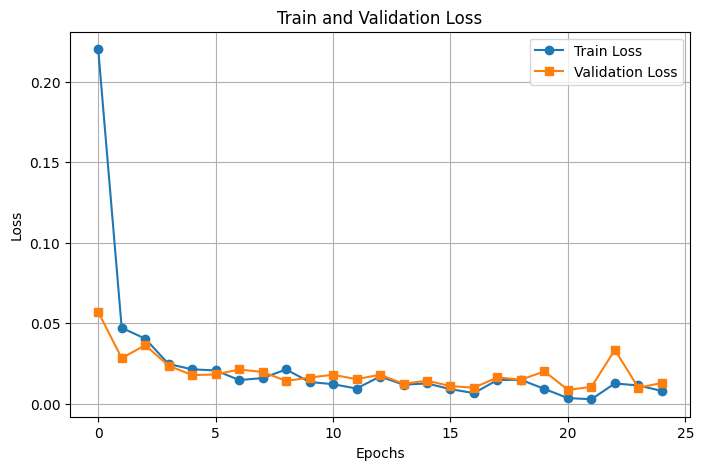

In [30]:
plot_losses(train_losses, val_losses)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score

def evaluate_model(model, X_tensor, y_tensor, dataset_name="Set"):
    model.eval()
    with torch.no_grad():
        probs = model(X_tensor).squeeze().numpy()
        preds = (probs >= 0.5).astype(int)
        true = y_tensor.squeeze().numpy()

    accuracy = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    roc_auc = roc_auc_score(true, probs)
    conf_mat = confusion_matrix(true, preds)

    print(f"📊 Evaluation on {dataset_name}")
    print(f"Accuracy      : {accuracy:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC Score : {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_mat)
    print("Classification Report:\n", classification_report(true, preds))
    print(f"Correct: {sum(true == preds)}, Incorrect: {len(true) - sum(true == preds)}")
    print("-" * 50)

    return probs, preds, true, conf_mat

In [32]:
test_probs, test_preds, test_true, test_cm = evaluate_model(model1, X_test_tensor, y_test_tensor, "Test Set")

📊 Evaluation on Test Set
Accuracy      : 0.9950
F1 Score      : 0.9950
ROC AUC Score : 0.9999
Confusion Matrix:
 [[996   4]
 [  6 994]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1000
         1.0       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000

Correct: 1990, Incorrect: 10
--------------------------------------------------


In [33]:
train_probs, train_preds, train_true, train_cm = evaluate_model(model1, X_train_tensor, y_train_tensor, "Training Set")

📊 Evaluation on Training Set
Accuracy      : 0.9992
F1 Score      : 0.9992
ROC AUC Score : 1.0000
Confusion Matrix:
 [[3197    3]
 [   2 3198]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3200
         1.0       1.00      1.00      1.00      3200

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400

Correct: 6395, Incorrect: 5
--------------------------------------------------


In [34]:
val_probs, val_preds, val_true, val_cm = evaluate_model(model1, X_val_tensor, y_val_tensor, "Validation Set")

📊 Evaluation on Validation Set
Accuracy      : 0.9962
F1 Score      : 0.9963
ROC AUC Score : 0.9999
Confusion Matrix:
 [[796   4]
 [  2 798]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       800
         1.0       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Correct: 1594, Incorrect: 6
--------------------------------------------------


In [35]:
import seaborn as sns
import pandas as pd

def plot_confidence_distribution(probs, true, preds, set_name):
    confidence_df = pd.DataFrame({
        'Confidence': probs,
        'True': true,
        'Pred': preds,
        'Set': set_name
    })

    plt.figure(figsize=(10,6))
    sns.scatterplot(x=range(len(confidence_df)), y='Confidence', hue='True',
                    style='Pred', data=confidence_df, palette='coolwarm', alpha=0.7)
    plt.title(f"Sample-wise Confidence with True and Predicted Labels in {set_name}")
    plt.xlabel("Sample Index")
    plt.ylabel("Model Confidence (Predicted Probability)")
    plt.axhline(0.5, linestyle='--', color='gray')
    plt.show()

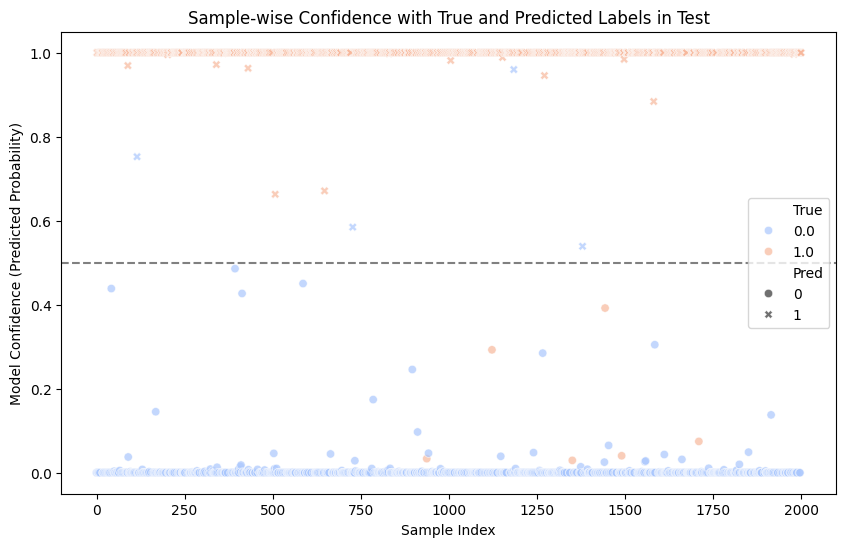

In [36]:
plot_confidence_distribution(test_probs, test_true, test_preds, "Test")

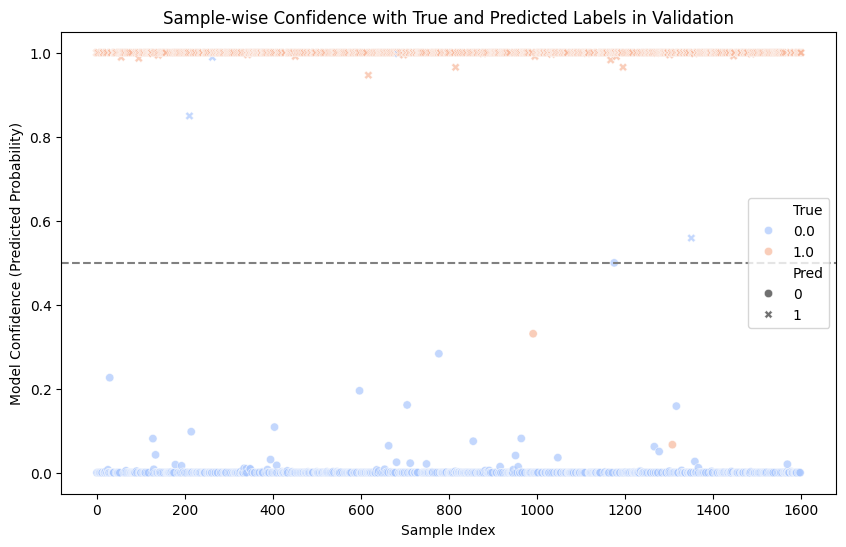

In [37]:
plot_confidence_distribution(val_probs, val_true, val_preds, "Validation")

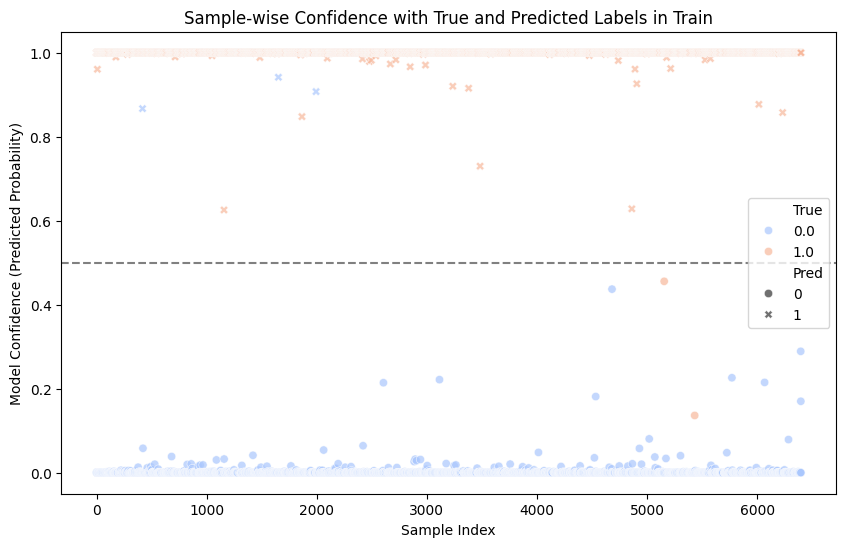

In [38]:
plot_confidence_distribution(train_probs, train_true, train_preds, "Train")

In [39]:
def plot_Boxplot(model_name):
  train_df = pd.DataFrame({
      'Confidence': train_probs,
      'True': train_true,
      'Pred': train_preds,
      'Set': 'Train'
  })
  val_df = pd.DataFrame({
      'Confidence': val_probs,
      'True': val_true,
      'Pred': val_preds,
      'Set': 'Validation'
  })

  test_df = pd.DataFrame({
      'Confidence': test_probs,
      'True': test_true,
      'Pred': test_preds,
      'Set': 'Test'
  })
  combined_df = pd.concat([train_df, val_df ,test_df]).reset_index()

  plt.figure(figsize=(10,6))
  sns.boxplot(data=combined_df, x='Set', y='Confidence', hue='True', palette='coolwarm')
  plt.title(f"Confidence Distribution {model_name} by True Class (Train, Validation, Test)")
  plt.axhline(0.5, color='gray', linestyle='--')
  plt.show()

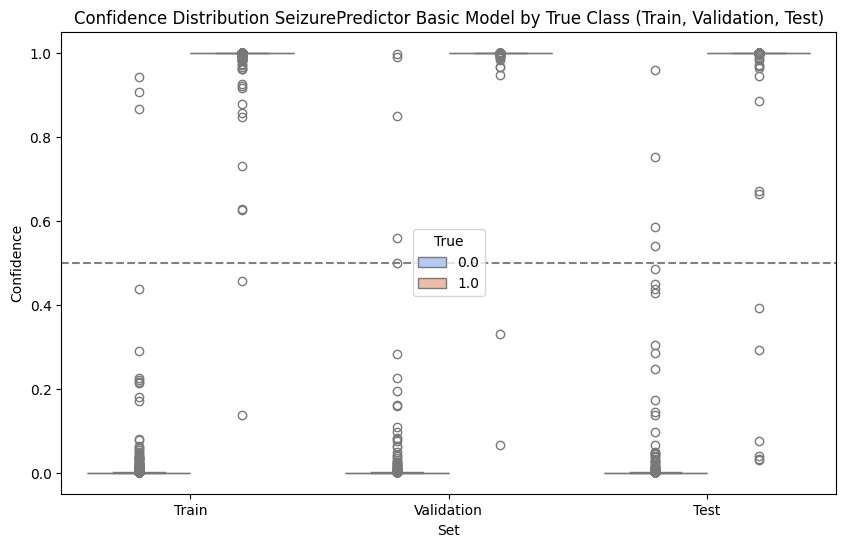

In [40]:
plot_Boxplot("SeizurePredictor Basic Model")

In [41]:
def plot_confusion_matrix(cm, set_name):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix {set_name}")
  plt.show()

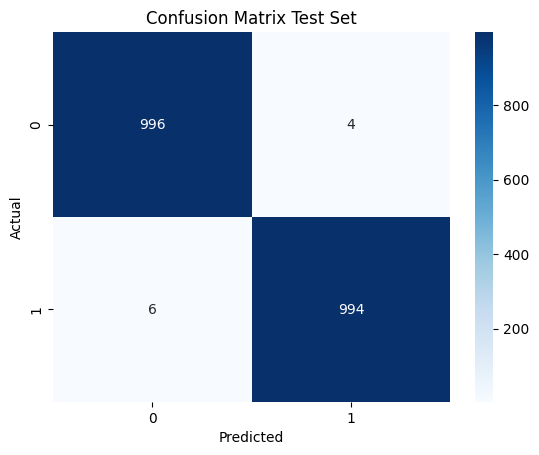

In [42]:
plot_confusion_matrix(test_cm, "Test Set")

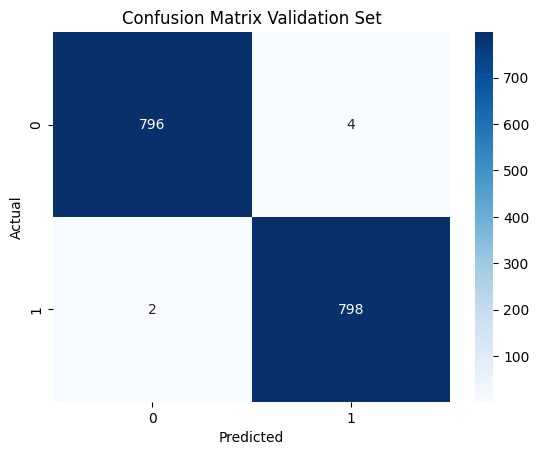

In [43]:
plot_confusion_matrix(val_cm, "Validation Set")

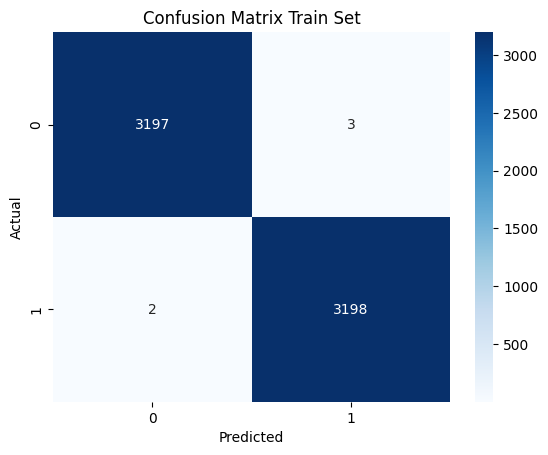

In [44]:
plot_confusion_matrix(train_cm, "Train Set")

In [45]:
class CNNSeizurePredictor(nn.Module):
    def __init__(self):
        super(CNNSeizurePredictor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),   # [B, 32, 178]
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=2),                 # [B, 32, 89]

            nn.Conv1d(32, 64, kernel_size=3, padding=1), # [B, 64, 89]
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),                 # [B, 64, 44]

            nn.Flatten(),                                # [B, 64*44]
            nn.Linear(64 * 44, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.cnn(x)

In [46]:
model2 = CNNSeizurePredictor()
train_losses, val_losses = perform_training(model2,train_loader, val_loader)

Epoch [1/25], Train Loss: 0.0930, Val Loss: 0.0222
Epoch [2/25], Train Loss: 0.0514, Val Loss: 0.0226
Epoch [3/25], Train Loss: 0.0308, Val Loss: 0.0144
Epoch [4/25], Train Loss: 0.0198, Val Loss: 0.0130
Epoch [5/25], Train Loss: 0.0187, Val Loss: 0.0146
Epoch [6/25], Train Loss: 0.0196, Val Loss: 0.0193
Epoch [7/25], Train Loss: 0.0161, Val Loss: 0.0093
Epoch [8/25], Train Loss: 0.0226, Val Loss: 0.0062
Epoch [9/25], Train Loss: 0.0080, Val Loss: 0.0122
Epoch [10/25], Train Loss: 0.0089, Val Loss: 0.0059
Epoch [11/25], Train Loss: 0.0044, Val Loss: 0.0037
Epoch [12/25], Train Loss: 0.0055, Val Loss: 0.0201
Epoch [13/25], Train Loss: 0.0191, Val Loss: 0.0237
Epoch [14/25], Train Loss: 0.0081, Val Loss: 0.0052
Epoch [15/25], Train Loss: 0.0080, Val Loss: 0.0063
Epoch [16/25], Train Loss: 0.0052, Val Loss: 0.0045
Epoch [17/25], Train Loss: 0.0058, Val Loss: 0.0017
Epoch [18/25], Train Loss: 0.0041, Val Loss: 0.0144
Epoch [19/25], Train Loss: 0.0021, Val Loss: 0.0074
Epoch [20/25], Train 

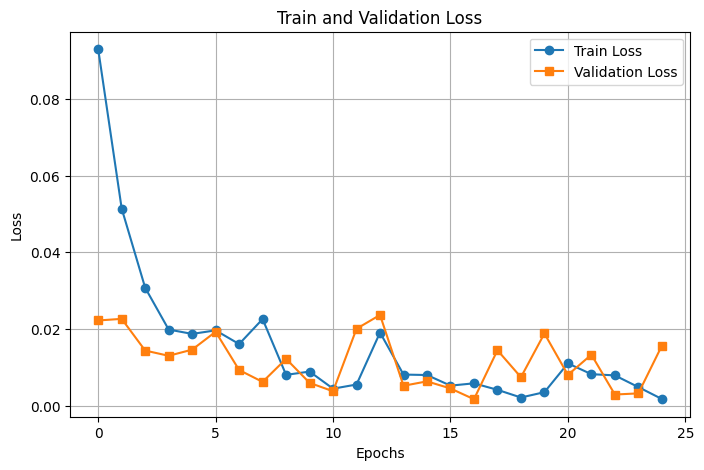

In [47]:
plot_losses(train_losses, val_losses)

📊 Evaluation on Test Set
Accuracy      : 0.9950
F1 Score      : 0.9950
ROC AUC Score : 1.0000
Confusion Matrix:
 [[1000    0]
 [  10  990]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1000
         1.0       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000

Correct: 1990, Incorrect: 10
--------------------------------------------------


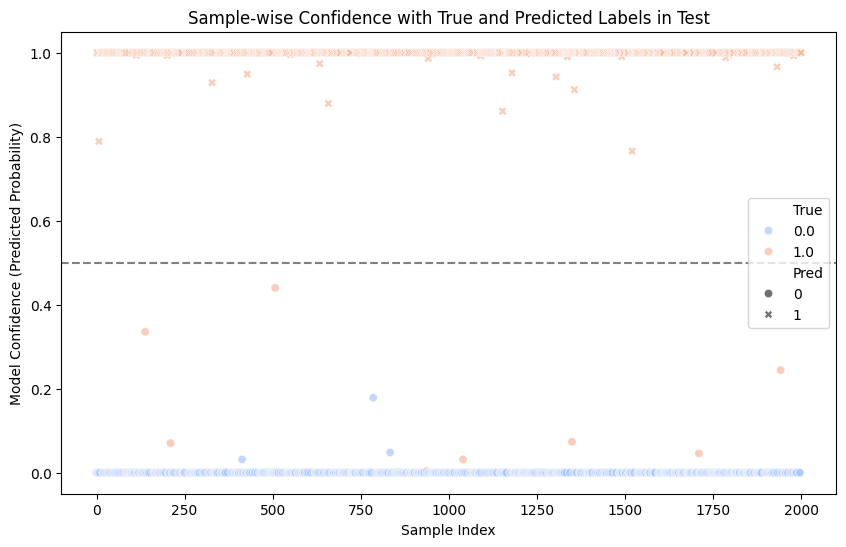

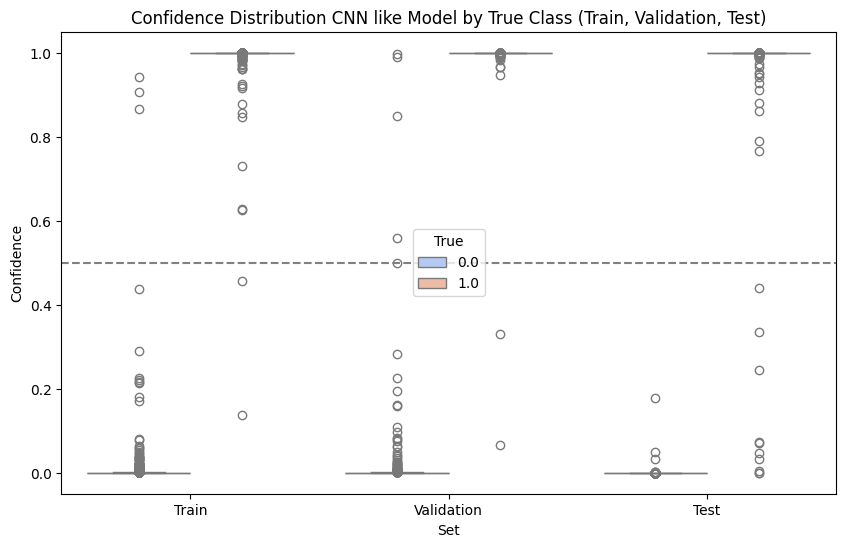

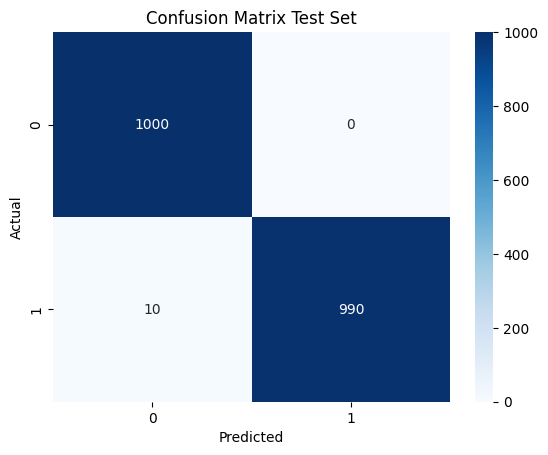

In [48]:
test_probs, test_preds, test_true, test_cm = evaluate_model(model2, X_test_tensor, y_test_tensor, "Test Set")

plot_confidence_distribution(test_probs, test_true, test_preds, "Test")
plot_Boxplot("CNN like Model")
plot_confusion_matrix(test_cm, "Test Set")

In [49]:
df_final.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X13.V1.122,40,36,31,23,13,9,2,-1,-3,...,-11,-13,-15,-17,-20,-30,-37,-49,-59,0
1,X17.V1.862,49,43,42,36,32,28,22,12,2,...,-25,-26,-31,-34,-31,-28,-23,-19,-16,0
2,X6.V1.862,24,26,30,27,27,28,29,25,29,...,-25,-30,-30,-23,-17,-9,1,6,13,0
3,X12.V1.802,29,35,38,32,26,24,28,34,40,...,-32,-32,-29,-28,-33,-36,-32,-34,-32,0
4,X5.V1.415,-12,-5,2,3,1,4,5,6,6,...,-14,-12,-7,-10,-14,-18,-13,-9,-3,0


In [50]:
X[:4,:2]

array([[40., 36.],
       [49., 43.],
       [24., 26.],
       [29., 35.]], dtype=float32)

In [51]:
X.shape

(10000, 178)

In [52]:
ey = np.expand_dims(y, axis=1)
ey.shape

(10000, 1)

In [53]:
ey[:4]

array([[0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [54]:
corr_matrix = np.corrcoef(X, rowvar=False)  # shape (178, 178)

abs_corr = np.abs(corr_matrix)
np.fill_diagonal(abs_corr, 0)

dependent_pairs = np.argwhere(abs_corr > 0.945)
print(dependent_pairs.shape)
print("Highly correlated feature pairs (indices) are:")
for i, j in dependent_pairs:
    print(f"Feature {i} and Feature {j} have correlation {corr_matrix[i, j]}")

(20, 2)
Highly correlated feature pairs (indices) are:
Feature 0 and Feature 1 have correlation 0.9460589855285112
Feature 1 and Feature 0 have correlation 0.9460589855285112
Feature 7 and Feature 8 have correlation 0.946433058072711
Feature 8 and Feature 7 have correlation 0.946433058072711
Feature 8 and Feature 9 have correlation 0.9460496615576656
Feature 9 and Feature 8 have correlation 0.9460496615576655
Feature 12 and Feature 13 have correlation 0.9452057170520101
Feature 13 and Feature 12 have correlation 0.9452057170520102
Feature 13 and Feature 14 have correlation 0.9519648183821757
Feature 14 and Feature 13 have correlation 0.9519648183821758
Feature 14 and Feature 15 have correlation 0.9486908368197853
Feature 15 and Feature 14 have correlation 0.9486908368197852
Feature 113 and Feature 114 have correlation 0.9460512128541266
Feature 114 and Feature 113 have correlation 0.9460512128541266
Feature 114 and Feature 115 have correlation 0.9481754445056427
Feature 115 and Feature

In [55]:
features_to_remove = set()
for i, j in dependent_pairs:
    if(((i,j) not in features_to_remove) and ((j,i) not in features_to_remove)):
      features_to_remove.add((i,j))
features_to_remove

{(np.int64(0), np.int64(1)),
 (np.int64(7), np.int64(8)),
 (np.int64(8), np.int64(9)),
 (np.int64(12), np.int64(13)),
 (np.int64(13), np.int64(14)),
 (np.int64(14), np.int64(15)),
 (np.int64(113), np.int64(114)),
 (np.int64(114), np.int64(115)),
 (np.int64(122), np.int64(123)),
 (np.int64(123), np.int64(124))}

In [56]:
removing = set()
for i, j in features_to_remove:
  removing.add(j)
removing.remove(1)
removing = list(map(int, removing))

In [57]:
X_reduced = np.delete(X, removing, axis=1)

In [58]:
X_reduced = X_reduced.reshape(10000, 13, 13)

In [59]:
X_reduced.shape

(10000, 13, 13)

In [60]:
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_reduced, ey, test_size=0.2, stratify=ey, random_state=42)

In [61]:
X_train_2d, X_Val_2d, y_train_2d, y_Val_2d = train_test_split(X_train_2d, y_train_2d, test_size=0.2, stratify=y_train_2d, random_state=42)

In [62]:
X_train_tensor_2d = torch.tensor(X_train_2d).unsqueeze(1)
X_test_tensor_2d = torch.tensor(X_test_2d).unsqueeze(1)
X_val_tensor_2d = torch.tensor(X_Val_2d).unsqueeze(1)
y_train_tensor_2d = torch.tensor(y_train_2d)
y_test_tensor_2d = torch.tensor(y_test_2d)
y_val_tensor_2d = torch.tensor(y_Val_2d)
print(X_train_tensor_2d.shape)
print(y_train_tensor_2d.shape)

torch.Size([6400, 1, 13, 13])
torch.Size([6400, 1])


In [63]:
train_loader_2d = DataLoader(TensorDataset(X_train_tensor_2d, y_train_tensor_2d), batch_size=64, shuffle=True)
test_loader_2d = DataLoader(TensorDataset(X_test_tensor_2d, y_test_tensor_2d), batch_size=len(X_test_tensor))
val_loader_2d = DataLoader(TensorDataset(X_val_tensor_2d, y_val_tensor_2d), batch_size=len(X_val_tensor))

In [64]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(BasicBlock, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class CustomResNet13x13(nn.Module):
    def __init__(self):
        super(CustomResNet13x13, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.res1 = BasicBlock(16, 32, downsample=True)  # 13x13 → 7x7
        self.res2 = BasicBlock(32, 64, downsample=True)  # 7x7 → 4x4

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 64x4x4 → 64x1x1
        self.classifier = nn.Sequential(
            nn.Flatten(),               # [batch, 64, 1, 1] → [batch, 64]
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.global_pool(x)
        return self.classifier(x)


In [65]:
model3 = CustomResNet13x13()
train_losses, val_losses = perform_training(model3,train_loader_2d, val_loader_2d)

Epoch [1/25], Train Loss: 0.1015, Val Loss: 0.0392
Epoch [2/25], Train Loss: 0.0436, Val Loss: 0.0287
Epoch [3/25], Train Loss: 0.0392, Val Loss: 0.0323
Epoch [4/25], Train Loss: 0.0365, Val Loss: 0.0311
Epoch [5/25], Train Loss: 0.0345, Val Loss: 0.0224
Epoch [6/25], Train Loss: 0.0325, Val Loss: 0.0262
Epoch [7/25], Train Loss: 0.0248, Val Loss: 0.0220
Epoch [8/25], Train Loss: 0.0272, Val Loss: 0.0494
Epoch [9/25], Train Loss: 0.0290, Val Loss: 0.0215
Epoch [10/25], Train Loss: 0.0300, Val Loss: 0.0380
Epoch [11/25], Train Loss: 0.0172, Val Loss: 0.0440
Epoch [12/25], Train Loss: 0.0181, Val Loss: 0.1550
Epoch [13/25], Train Loss: 0.0126, Val Loss: 0.0164
Epoch [14/25], Train Loss: 0.0151, Val Loss: 0.0184
Epoch [15/25], Train Loss: 0.0160, Val Loss: 0.0847
Epoch [16/25], Train Loss: 0.0128, Val Loss: 0.0117
Epoch [17/25], Train Loss: 0.0106, Val Loss: 0.0145
Epoch [18/25], Train Loss: 0.0191, Val Loss: 0.0151
Epoch [19/25], Train Loss: 0.0112, Val Loss: 0.0169
Epoch [20/25], Train 

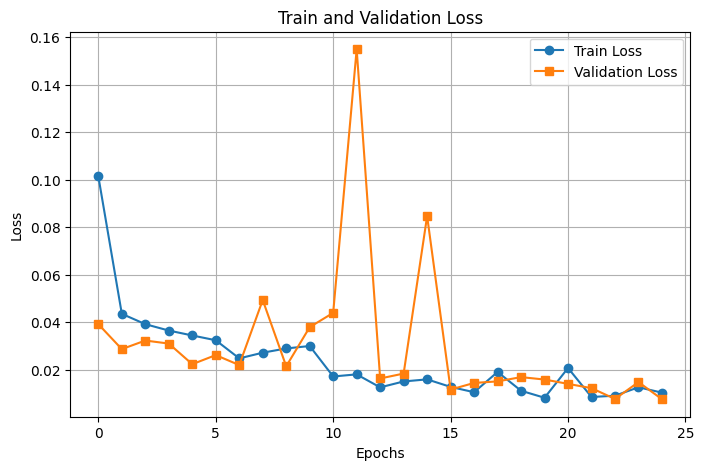

In [66]:
plot_losses(train_losses, val_losses)

📊 Evaluation on Test Set
Accuracy      : 0.9980
F1 Score      : 0.9980
ROC AUC Score : 0.9999
Confusion Matrix:
 [[997   3]
 [  1 999]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Correct: 1996, Incorrect: 4
--------------------------------------------------


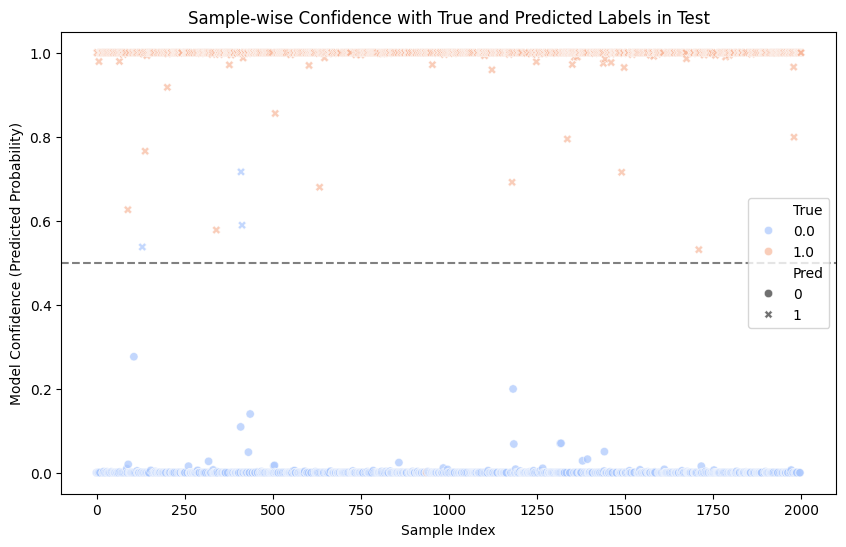

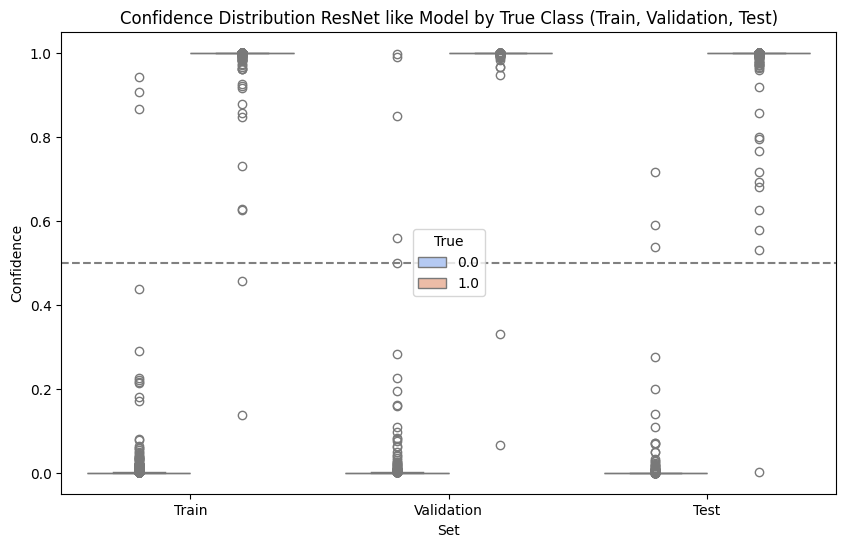

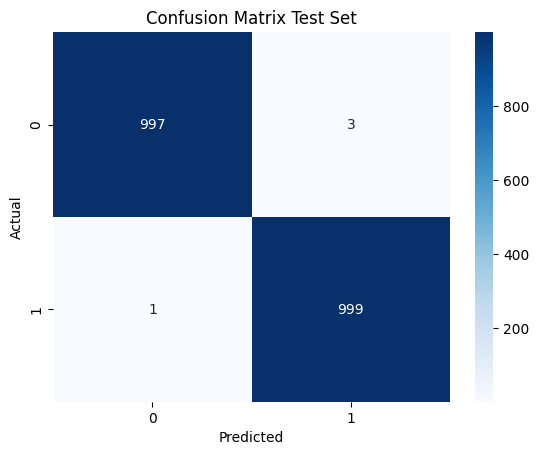

In [67]:
test_probs, test_preds, test_true, test_cm = evaluate_model(model3, X_test_tensor_2d, y_test_tensor_2d, "Test Set")

plot_confidence_distribution(test_probs, test_true, test_preds, "Test")
plot_Boxplot("ResNet like Model")
plot_confusion_matrix(test_cm, "Test Set")

In [79]:
def final_evaluation(model1, model2, model3, X_tensor, y_tensor,X_test_tensor_2d, y_test_tensor_2d):
    results = {}

    # Evaluate each model
    for i, model in enumerate([model1, model2, model3], start=1):
        if i==3:
            probs, preds, true, _ = evaluate_model(model, X_test_tensor_2d, y_test_tensor_2d, dataset_name=f"Model {i}")
        else:
          probs, preds, true, _ = evaluate_model(model, X_tensor, y_tensor, dataset_name=f"Model {i}")
        results[f'probs_{i}'] = probs
        results[f'preds_{i}'] = preds
        if i == 1:
            results['true'] = true  # Store true only once

    # Create DataFrame
    df = pd.DataFrame(results)
    return df

In [80]:
df_eval = final_evaluation(model1, model2, model3, X_test_tensor, y_test_tensor,X_test_tensor_2d, y_test_tensor_2d)

📊 Evaluation on Model 1
Accuracy      : 0.9950
F1 Score      : 0.9950
ROC AUC Score : 0.9999
Confusion Matrix:
 [[996   4]
 [  6 994]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1000
         1.0       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000

Correct: 1990, Incorrect: 10
--------------------------------------------------
📊 Evaluation on Model 2
Accuracy      : 0.9950
F1 Score      : 0.9950
ROC AUC Score : 1.0000
Confusion Matrix:
 [[1000    0]
 [  10  990]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1000
         1.0       1.00      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000

In [81]:
df_eval.head()

,probs_1,preds_1,true,probs_2,preds_2,probs_3,preds_3
0,0.000103,0,0.0,1.914856e-08,0,0.000006,0
1,1.000000,1,1.0,1.000000e+00,1,1.000000,1
2,0.000015,0,0.0,3.699489e-08,0,0.000025,0
3,1.000000,1,1.0,1.000000e+00,1,0.999824,1
4,0.001145,0,0.0,3.810959e-07,0,0.000142,0


In [82]:
df_eval['preds_sum'] = df_eval[['preds_1', 'preds_2', 'preds_3']].sum(axis=1)
df_eval['preds_consensus'] = (df_eval['preds_sum'] == 0) | (df_eval['preds_sum'] == 3)

In [76]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def train_svm_on_model_probs(df, test_size=0.2, random_state=42):
    X = df[['probs_1', 'probs_2', 'probs_3', 'preds_sum', 'preds_consensus']].values
    y = df['true'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    svm = SVC(kernel='rbf', probability=True, random_state=random_state)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    y_probs = svm.predict_proba(X_test)[:, 1]

    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    conf_mat = confusion_matrix(y_test, y_pred)

    print("📈 SVM Meta-Classifier Performance")
    print(f"Accuracy      : {acc:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC Score : {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_mat)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return svm

In [77]:
svm_meta_model = train_svm_on_model_probs(df_eval)

📈 SVM Meta-Classifier Performance
Accuracy      : 1.0000
F1 Score      : 1.0000
ROC AUC Score : 1.0000
Confusion Matrix:
 [[200   0]
 [  0 200]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

